# Deep Learning for NLP - Project

RULES:

* Do not create any additional cell

* Fill in the blanks

* All cells should be runnable (modulo trivial compatibility bugs that we'd fix)

* 4 / 20 points will be allocated to the clarity of your code

* Efficient code will have a bonus

DELIVERABLE:

* this notebook
* the predictions of the SST test set

DO NOT INCLUDE THE DATASETS IN THE DELIVERABLE..

In [1]:
import io
import os
import numpy as np
import scipy
from scipy.stats import randint as sp_randint
import scipy.linalg
import sklearn.linear_model
import sklearn.ensemble
import sklearn.datasets
import sklearn.decomposition
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
import time
import requests  # proper streaming download
from tqdm import tqdm  # Good looking loading bar
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
PATH_TO_DATA = "data/"

# 1) Monolingual (English) word embeddings 

In [3]:
class Word2vec():
    def __init__(self, fname, nmax=100000):
        self.load_wordvec(fname, nmax)
        # self.word2id = dict.fromkeys(self.word2vec.keys()) # Doesn't have the expected behaviour I guess
        # We define the id as the order of appearance of the word
        self.word2id = {}
        for i, value in enumerate(self.word2vec.keys()):
            self.word2id[value] = i
        self.id2word = {v: k for k, v in self.word2id.items()}
        self.embeddings = np.array(list(self.word2vec.values()))
    
    def load_wordvec(self, fname, nmax):
        self.word2vec = {}
        with io.open(fname, encoding='utf-8') as f:
            next(f)
            for i, line in enumerate(f):
                word, vec = line.split(' ', 1)
                self.word2vec[word] = np.fromstring(vec, sep=' ')
                if i == (nmax - 1):
                    break
        print('Loaded %s pretrained word vectors' % (len(self.word2vec)))

    def most_similar(self, w, K=5):
        # K most similar words: self.score  -  np.argsort
        # We assume that we have K <= len(self.w2v) - 1
        scores = [self.score(w, w2) for w2 in self.word2vec.keys()]
        return [self.id2word[word_id] for word_id in np.argsort(scores)[-K:]]

    def score(self, w1, w2):
        # cosine similarity: np.dot  -  np.linalg.norm
        # using np is faster than using scipy.spatial.cosine
        try:
            v1 = self.word2vec[w1]
            v2 = self.word2vec[w2]
        except KeyError: # One of the 2 words is not present in the DB
            return 0
        return np.dot(v1, v2)/(np.linalg.norm(v1)*np.linalg.norm(v2))


In [4]:
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=30000)
# nmax was set to 100000 to be sure that 'paris' and 'berlin' are loaded

# You will be evaluated on the output of the following:
for w1, w2 in zip(('cat', 'dog', 'dogs', 'paris', 'germany'), ('dog', 'pet', 'cats', 'france', 'berlin')):
    print(w1, w2, w2v.score(w1, w2))
for w1 in ['cat', 'dog', 'dogs', 'paris', 'germany']:
    print(w2v.most_similar(w1))

Loaded 30000 pretrained word vectors
cat dog 0.671683666279249
dog pet 0.6842064029669219
dogs cats 0.7074389328052404
paris france 0.7775108541288563
germany berlin 0
['feline', 'kitten', 'kitty', 'cats', 'cat']
['canine', 'Dog', 'puppy', 'dogs', 'dog']
['cats', 'puppies', 'Dogs', 'dog', 'dogs']
['europe', 'london', 'Paris', 'france', 'paris']
['Germany', 'france', 'german', 'europe', 'germany']


In [5]:
class BoV():
    def __init__(self, w2v):
        self.w2v = w2v
    
    def encode(self, sentences, idf=False):
        # takes a list of sentences, outputs a numpy array of sentence embeddings
        # see TP1 for help
        sentemb = []
        for sent in sentences:
            if idf is False:
                # mean of word vectors
                codes = []
                for w in sent:
                    try:
                        codes.append(self.w2v.word2vec[w])
                    except KeyError: # ignore unknown words
                        pass
                if len(codes) != 0:
                    sentemb.append(np.mean(codes, axis=0))
                else:
                    sentemb.append(np.zeros(self.w2v.embeddings[0].shape[0]))
            else:
                # idf-weighted mean of word vectors
                codes = []
                for w in sent:
                    try:
                        codes.append(idf[w] * self.w2v.word2vec[w])
                    except KeyError: # ignore unknown words
                        pass
                if len(codes) != 0:
                    sentemb.append(np.mean(codes, axis=0))
                else:
                    sentemb.append(np.zeros(self.w2v.embeddings[0].shape[0]))
        return np.vstack(sentemb)

    def most_similar(self, s, sentences, idf=False, K=5):
        # get most similar sentences and **print** them
        keys = self.encode(sentences, idf)
        query = self.encode([s], idf)[0]
        scores = np.dot(keys, np.transpose(query)) / (np.linalg.norm(keys, axis=1) * np.linalg.norm(query))
        res = [sentences[s_id] for s_id in np.argsort(scores)[-K:]]
        print(res)
        return res

    def score(self, s1, s2, idf=False):
        # cosine similarity: use   np.dot  and  np.linalg.norm
        v1 = self.encode([s1], idf)[0]
        v2 = self.encode([s2], idf)[0]
        print(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))
        return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
    
    def build_idf(self, sentences):
        # build the idf dictionary: associate each word to its idf value
        df = {}
        for sentence in sentences: # counting frequency of words
            for w in set(sentence): # only check if a word appears or not in a sentence
                df[w] = df.get(w, 0) + 1
        D = len(sentences)
        return {word: max(1, np.log10(D / df[word])) for word in df.keys()}

In [6]:
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=100000)
s2v = BoV(w2v)

# Load sentences in "PATH_TO_DATA/sentences.txt"
sentences = []
with io.open(os.path.join(PATH_TO_DATA, 'sentences.txt'), encoding='utf-8') as f:
    next(f)
    for i, line in enumerate(f):
        sentences.append(line.strip().split(' ')) # removing leading and trailing whitespaces

# Build idf scores for each word
idf = s2v.build_idf(sentences)

# You will be evaluated on the output of the following:
s2v.most_similar('' if not sentences else sentences[10], sentences)  # BoV-mean
s2v.score('' if not sentences else sentences[7], '' if not sentences else sentences[13])


idf = s2v.build_idf(sentences)
s2v.most_similar('' if not sentences else sentences[10], sentences, idf)  # BoV-idf
s2v.score('' if not sentences else sentences[7], '' if not sentences else sentences[13], idf)

Loaded 100000 pretrained word vectors
[['a', 'man', 'in', 'a', 'white', 'shirt', 'squirting', 'a', 'bottle', 'of', 'a', 'drink', 'and', 'smiling', '.'], ['a', 'man', 'in', 'a', 'black', 'jacket', 'with', 'a', 'white', 'stripe', 'on', 'the', 'sleeve', 'is', 'holding', 'a', 'drink', 'and', 'laughing', 'while', 'a', 'woman', 'watches', '.'], ['a', 'woman', 'in', 'a', 'blue', 'shirt', 'is', 'laughing', 'with', 'a', 'woman', 'in', 'a', 'black', 'shirt', 'outside', ',', 'as', 'people', 'are', 'sitting', 'and', 'standing', 'all', 'around', 'them', '.'], ['a', 'man', 'in', 'a', 'pink', 'shirt', 'and', 'a', 'woman', 'in', 'a', 'teal', 'shirt', ',', 'who', 'is', 'drinking', 'wine', ',', 'are', 'sitting', 'in', 'a', 'dark', 'corner', 'and', 'talking', '.'], ['1', 'woman', 'in', 'a', 'black', 'jacket', 'is', 'drinking', 'out', 'of', 'a', 'bottle', 'while', 'others', 'are', 'smiling', '.']]
0.7894217938961857
[['a', 'man', 'in', 'a', 'yellow', 'shirt', 'and', 'jeans', 'is', 'walking', 'down', 'the'

0.6997092997150145

# 2) Multilingual (English-French) word embeddings

Let's consider a bilingual dictionary of size V_a (e.g French-English).

Let's define **X** and **Y** the **French** and **English** matrices.

They contain the embeddings associated to the words in the bilingual dictionary.

We want to find a **mapping W** that will project the source word space (e.g French) to the target word space (e.g English).

Procrustes : **W\* = argmin || W.X - Y ||  s.t  W^T.W = Id**
has a closed form solution:
**W = U.V^T  where  U.Sig.V^T = SVD(Y.X^T)**

In what follows, you are asked to: 

In [7]:
# 1 - Download and load 50k first vectors of
#     https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.en.vec
#     https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.fr.vec

en_url = "https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.en.vec"
fr_url = "https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.fr.vec"

def get_raw_data(url, max_lines = 5):
    res = {}
    line_nb = 0
    with requests.get(url, stream=True) as r:  # Clean streaming download and connection handling
        for line in tqdm(r.iter_lines(), total=max_lines):  # Good looking download bar
            if line:
                line_nb += 1
                if line_nb != 1:
                    temp = line.decode('utf-8')  # Converting bytes to string
                    word, vec = temp.split(' ', 1)  # Using same code as above to create the dict
                    res[word] = np.fromstring(vec, sep=' ')
                    if line_nb == max_lines + 1:
                        break
    return res

english = get_raw_data(en_url, 50000)
french = get_raw_data(fr_url, 50000)

 33%|███████████████████████████████████████████████████████████████▋                                                                                                                                | 16599/50000 [00:03<00:05, 6260.27it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 39494/50000 [00:07<00:02, 4183.07it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 49876/50000 [00:28<00:00, 5096.19it/s]

In [8]:
# 2 - Get words that appear in both vocabs (= identical character strings)
#     Use it to create the matrix X and Y (of aligned embeddings for these words)

common_words = np.intersect1d(list(english.keys()), list(french.keys()))
print("Number of common words:", len(common_words))

X = []
Y = []

for i, w in np.ndenumerate(common_words):
    X.append(list(french[w]))
    Y.append(list(english[w]))

X = np.vstack(X)
Y = np.vstack(Y)

Number of common words: 18970


In [9]:
# 3 - Solve the Procrustes using the scipy package and: scipy.linalg.svd() and get the optimal W
#     Now W*French_vector is in the same space as English_vector

U, s, V_t = scipy.linalg.svd(Y.transpose().dot(X), full_matrices=True)
W = U.dot(V_t)
del U
del s
del V_t

In [10]:
# 4 - After alignment with W, give examples of English nearest neighbors of some French words (and vice versa)
#     You will be evaluated on that part and the code above


# Just a quick class to avoid reading a file compared to the first class we wrote
class Translate():
    def __init__(self, dep, arr, W):
        self.input = dep
        self.output = arr
        self.W = W
        self.word2id = {}
        for i, value in enumerate(self.output.keys()):
            self.word2id[value] = i
        self.id2word = {v: k for k, v in self.word2id.items()}
        self.embeddings = list(self.output.values())
    
    def most_similar(self, w_i, K=5):
        # K most similar words: self.score  -  np.argsort
        # We assume that we have K <= len(self.w2v) - 1
        v1 = self.get_vec_in(w_i)
        scores = [self.score_vec(v1, v2) for v2 in self.embeddings]
        return [self.id2word[word_id] for word_id in np.argsort(scores)[-K:]]

    def get_vec_in(self, word):
        return self.W.dot(self.input[word].transpose()).transpose()

    def score_vec(self, v1, v2):
        return np.dot(v1, v2)/(np.linalg.norm(v1)*np.linalg.norm(v2))

w2v = Translate(french, english, W)

for w1 in ['chat', 'chien', 'chiens', 'paris', 'allemagne', 'merci', 'adieu', 'parfait']: # The last word is the most probable one
    print(w2v.most_similar(w1))

['poodle', 'feline', 'hamster', 'rabbit', 'cat']
['spaniel', 'dogs', 'terrier', 'poodle', 'dog']
['hares', 'hounds', 'dog', 'rabbits', 'dogs']
['sorbonne', 'gallimard', 'rouen', 'parisian', 'paris']
['bavaria', 'saarland', 'gelsenkirchen', 'rhineland', 'germany']
['talk/', 'utc', 'thankyou', 'anyways', 'thank']
['vous', 'encore', 'amour', 'goodbye', 'farewell']
['ideal', 'simple', 'imperfect', 'perfection', 'perfect']


If you want to dive deeper on this subject: https://github.com/facebookresearch/MUSE

# 3) Sentence classification with BoV and scikit-learn

In [11]:
# 1 - Load train/dev/test of Stanford Sentiment TreeBank (SST)
#     (https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)

def read_file(fname, has_cat=True):
    X = []
    Y = []
    with io.open(os.path.join(PATH_TO_DATA, 'SST/' + fname), encoding='utf-8') as f:
        next(f)  # skipping first line
        for i, line in enumerate(f):
            if has_cat:
                cat, sent = line.strip().split(' ', 1)
            else:
                sent = line.strip()
                cat = 0
            X.append(sent.split(' '))
            Y.append(int(cat))
    print('Loaded %s sentences' % (len(X)))
    return X, Y

X_train, Y_train = read_file("stsa.fine.train")
X_dev, Y_dev = read_file("stsa.fine.dev")
X_test, _ = read_file("stsa.fine.test.X", False)

Loaded 8543 sentences
Loaded 1100 sentences
Loaded 2209 sentences


In [23]:
# 2 - Encode sentences with the BoV model above

w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=100000)
s2v = BoV(w2v)
idf = s2v.build_idf(sentences)

#average
train_sent = s2v.encode(X_train)
dev_sent = s2v.encode(X_dev)
test_sent = s2v.encode(X_test)

#Weighted average
#train_sent = s2v.encode(X_train, idf)
#dev_sent = s2v.encode(X_dev, idf)
#test_sent = s2v.encode(X_test, idf)

Loaded 100000 pretrained word vectors


LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=2000, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=0, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)

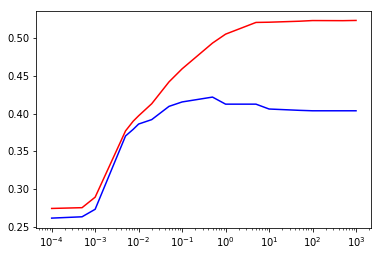

In [24]:
# 3 - Learn Logistic Regression on top of sentence embeddings using scikit-learn
#     (consider tuning the L2 regularization on the dev set)

x_train, x_test, y_train, y_test = train_test_split(train_sent, Y_train, test_size=0.2, shuffle=True)

C = [0.0001, 0.0005, 0.001, 0.005, 0.0075, 0.01, 0.02, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000]
acc = []
for c in C:
    clf = sklearn.linear_model.LogisticRegression(random_state=0, C=c, max_iter=2000, solver='newton-cg', multi_class='multinomial')
    clf.fit(x_train, y_train)
    acc.append([clf.score(x_train, y_train), clf.score(x_test, y_test)])

acc = np.array(acc)
plt.plot(C, acc[:, 0], c='r')
plt.plot(C, acc[:, 1], c='b')
plt.xscale('log')

clf = sklearn.linear_model.LogisticRegression(random_state=0, C=C[acc[:, 1].argsort()[-1]], max_iter=2000, solver='newton-cg', multi_class='multinomial')
clf.fit(x_train, y_train)

In [25]:
# 4 - Produce 2210 predictions for the test set (in the same order). One line = one prediction (=0,1,2,3,4).
#     Attach the output file "logreg_bov_y_test_sst.txt" to your deliverable.
#     You will be evaluated on the results of the test set.

predictions = clf.predict(test_sent)
file = open("logreg_bov_y_test_sst.txt", "w")
for p in predictions:
    file.write(str(p) + "\n")
file.close()

In [26]:
# BONUS!
# 5 - Try to improve performance with another classifier
#     Attach the output file "XXX_bov_y_test_sst.txt" to your deliverable (where XXX = the name of the classifier)

pca = sklearn.decomposition.PCA(n_components=200)
train_red = pca.fit_transform(train_sent)
print(np.sum(pca.explained_variance_ratio_))


clf = sklearn.ensemble.RandomForestClassifier(max_features=70, max_depth=10, n_estimators=1000, min_samples_leaf=1 ,n_jobs=8, oob_score=True)
clf.fit(train_red, Y_train)

predictions = clf.predict(pca.transform(test_sent))
file = open("RFC_bov_y_test_sst.txt", "w")
for p in predictions:
    file.write(str(p) + "\n")
file.close()

0.9287158157353917


# 4) Sentence classification with LSTMs in Keras

## 4.1 - Preprocessing

In [27]:
import tensorflow as tf
import keras

Using TensorFlow backend.


In [28]:
# 1 - Load train/dev/test sets of SST
PATH_TO_DATA = "data/"

def read_file(fname, has_cat=True):
    X = []
    Y = []
    with io.open(os.path.join(PATH_TO_DATA, 'SST/' + fname), encoding='utf-8') as f:
        next(f)  # skipping first line
        for i, line in enumerate(f):
            if has_cat:
                cat, sent = line.strip().split(' ', 1)
                cat2 = [0,0,0,0,0]
                cat2[int(cat)] = 1
                cat = cat2
            else:
                sent = line.strip()
                cat = [0,0,0,0,0]
            X.append(sent)
            Y.append(cat)
    print('Loaded %s sentences' % (len(X)))
    return X, Y

X_train, Y_train = read_file("stsa.fine.train")
X_dev, Y_dev = read_file("stsa.fine.dev")
X_test, _ = read_file("stsa.fine.test.X", False)


Loaded 8543 sentences
Loaded 1100 sentences
Loaded 2209 sentences


In [29]:
# 2 - Transform text to integers using keras.preprocessing.text.one_hot function
#     https://keras.io/preprocessing/text/

total = X_train + X_dev + X_test
total = " ".join(total)
words = set(keras.preprocessing.text.text_to_word_sequence(total))
n = len(words)
print("Total number of words :", n)

train_enc = [keras.preprocessing.text.one_hot(sent, round(n * 1.2)) for sent in X_train] 
dev_enc = [keras.preprocessing.text.one_hot(sent, round(n * 1.2)) for sent in X_dev] 
test_enc = [keras.preprocessing.text.one_hot(sent, round(n * 1.2)) for sent in X_test] 
print("Examples :", dev_enc[:5])

Total number of words : 17837
Examples : [[12345, 1090, 9079, 1224, 11968], [7831, 876, 3632, 13777, 19490, 12296, 1602, 1224, 7918, 10222, 12296, 15382, 1224, 3249, 2880, 6367, 10222, 21376, 15440, 7367, 8071, 19730, 1721, 3461, 876, 13266, 12296, 20528, 16206], [4782, 4457, 9516, 13221, 4455, 8169, 21025, 1224, 9658, 6860, 14898, 7635, 738, 10094, 17700], [6432, 21373, 21300, 737, 12296, 1350, 14074, 3088, 21243, 15440, 8014, 1692, 14898, 5100, 6555, 15818], [18164, 20255, 12985, 20860, 1224, 2579, 8762, 9159, 1357, 12383, 5232, 9906, 8567, 6454]]


**Padding input data**

Models in Keras (and elsewhere) take batches of sentences of the same length as input. It is because Deep Learning framework have been designed to handle well Tensors, which are particularly suited for fast computation on the GPU.

Since sentences have different sizes, we "pad" them. That is, we add dummy "padding" tokens so that they all have the same length.

The input to a Keras model thus has this size : (batchsize, maxseqlen) where maxseqlen is the maximum length of a sentence in the batch.

In [30]:
# 3 - Pad your sequences using keras.preprocessing.sequence.pad_sequences
#     https://keras.io/preprocessing/sequence/

total = X_train + X_dev + X_test
max_len = max(list(map(len, total)))
print("Maximum sentence length : ", max_len)

train_pad = keras.preprocessing.sequence.pad_sequences(train_enc, maxlen=round(max_len*1.2), value=0)
dev_pad = keras.preprocessing.sequence.pad_sequences(dev_enc, maxlen=round(max_len*1.2), value=0)
test_pad = keras.preprocessing.sequence.pad_sequences(test_enc, maxlen=round(max_len*1.2), value=0)

print("Example :", train_pad[0])

Maximum sentence length :  283
Example : [    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0    

## 4.2 - Design and train your model

In [41]:
# 4 - Design your encoder + classifier using keras.layers
#     In Keras, Torch and other deep learning framework, we create a "container" which is the Sequential() module.
#     Then we add components to this contained : the lookuptable, the LSTM, the classifier etc.
#     All of these components are contained in the Sequential() and are trained together.

from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Activation

embed_dim  = 32  # word embedding dimension
nhid       = 64  # number of hidden units in the LSTM
vocab_size = n + 1  # size of the vocabulary (see above +1 for dummy padding)
n_classes  = 5

model = Sequential()
model.add(Embedding(vocab_size, embed_dim))
model.add(LSTM(nhid, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(n_classes, activation='softmax'))


In [42]:
# 5 - Define your loss/optimizer/metrics

loss_classif     =  'categorical_crossentropy' # find the right loss for multi-class classification
optimizer        =  'adam' # find the right optimizer
metrics_classif  =  ['accuracy']

# Observe how easy (but blackboxed) this is in Keras
model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 32)          570816    
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                24832     
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 325       
Total params: 595,973
Trainable params: 595,973
Non-trainable params: 0
_________________________________________________________________
None


Train on 880 samples, validate on 220 samples
Epoch 1/6
880/880 [==============================] - ETA: 40s - loss: 1.6099 - acc: 0.28 - ETA: 25s - loss: 1.6112 - acc: 0.20 - ETA: 20s - loss: 1.6099 - acc: 0.20 - ETA: 17s - loss: 1.6089 - acc: 0.21 - ETA: 15s - loss: 1.6092 - acc: 0.20 - ETA: 13s - loss: 1.6079 - acc: 0.23 - ETA: 12s - loss: 1.6080 - acc: 0.24 - ETA: 11s - loss: 1.6070 - acc: 0.25 - ETA: 10s - loss: 1.6070 - acc: 0.24 - ETA: 10s - loss: 1.6074 - acc: 0.22 - ETA: 9s - loss: 1.6065 - acc: 0.2301 - ETA: 9s - loss: 1.6054 - acc: 0.242 - ETA: 8s - loss: 1.6041 - acc: 0.257 - ETA: 7s - loss: 1.6037 - acc: 0.256 - ETA: 7s - loss: 1.6026 - acc: 0.258 - ETA: 6s - loss: 1.6019 - acc: 0.253 - ETA: 5s - loss: 1.6023 - acc: 0.246 - ETA: 5s - loss: 1.6014 - acc: 0.250 - ETA: 4s - loss: 1.6000 - acc: 0.245 - ETA: 4s - loss: 1.5994 - acc: 0.245 - ETA: 3s - loss: 1.5986 - acc: 0.251 - ETA: 2s - loss: 1.5988 - acc: 0.251 - ETA: 2s - loss: 1.5993 - acc: 0.250 - ETA: 1s - loss: 1.5994 - a

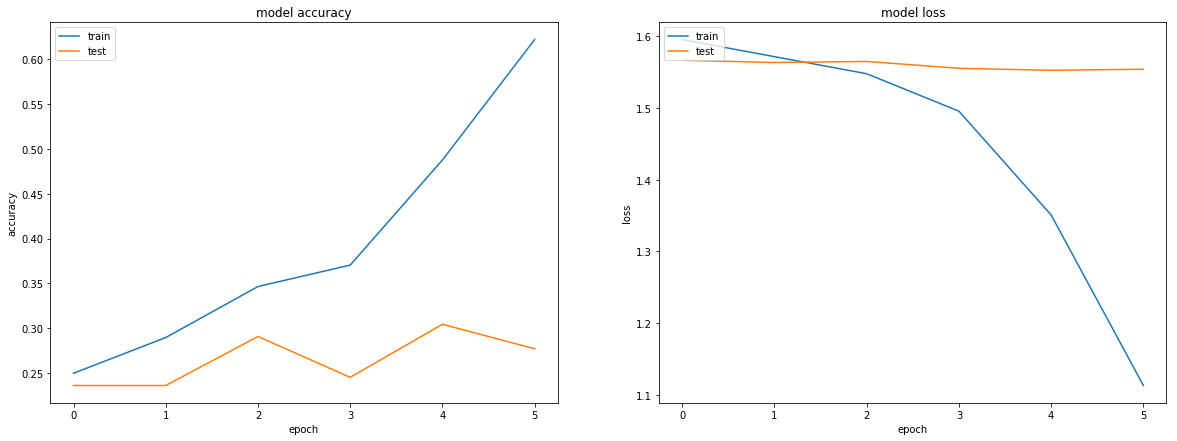

In [43]:
# 6 - Train your model and find the best hyperparameters for your dev set
#     you will be evaluated on the quality of your predictions on the test set

def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
    ax1.plot(history.history['acc'])
    ax1.plot(history.history['val_acc'])
    ax1.set_title('model accuracy')
    ax1.set_ylabel('accuracy')
    ax1.set_xlabel('epoch')
    ax1.legend(['train', 'test'], loc='upper left')
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('model loss')
    ax2.set_ylabel('loss')
    ax2.set_xlabel('epoch')
    ax2.legend(['train', 'test'], loc='upper left')

bs = 32
n_epochs = 6

history = model.fit(dev_pad, np.vstack(Y_dev), batch_size=bs, epochs=n_epochs, validation_split=0.2, verbose=1)

plot_history(history)

In [45]:
# 7 - Generate your predictions on the test set using model.predict(x_test)
#     https://keras.io/models/model/
#     Log your predictions in a file (one line = one integer: 0,1,2,3,4)
#     Attach the output file "logreg_lstm_y_test_sst.txt" to your deliverable.

model = Sequential()
model.add(Embedding(vocab_size, embed_dim))
model.add(LSTM(nhid, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(n_classes, activation='softmax'))
model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
model.fit(train_pad, np.vstack(Y_train), batch_size=32, epochs=4, verbose=1)
predictions = model.predict(test_pad)

file = open("logreg_lstm_y_test_sst.txt", "w")
for p in predictions:
    file.write(str(np.argmax(p)+1) + "\n")
file.close()

Epoch 1/4


6624/8543 [======================>.......] - ETA: 8:10 - loss: 1.6088 - acc: 0.218 - ETA: 5:10 - loss: 1.6083 - acc: 0.187 - ETA: 4:08 - loss: 1.6086 - acc: 0.197 - ETA: 3:40 - loss: 1.6100 - acc: 0.195 - ETA: 3:20 - loss: 1.6091 - acc: 0.212 - ETA: 3:06 - loss: 1.6096 - acc: 0.203 - ETA: 2:58 - loss: 1.6081 - acc: 0.232 - ETA: 2:50 - loss: 1.6078 - acc: 0.234 - ETA: 2:45 - loss: 1.6069 - acc: 0.239 - ETA: 2:41 - loss: 1.6070 - acc: 0.240 - ETA: 2:37 - loss: 1.6064 - acc: 0.238 - ETA: 2:34 - loss: 1.6059 - acc: 0.237 - ETA: 2:31 - loss: 1.6055 - acc: 0.238 - ETA: 2:29 - loss: 1.6041 - acc: 0.245 - ETA: 2:26 - loss: 1.6030 - acc: 0.252 - ETA: 2:25 - loss: 1.6019 - acc: 0.250 - ETA: 2:23 - loss: 1.6009 - acc: 0.250 - ETA: 2:22 - loss: 1.6004 - acc: 0.255 - ETA: 2:20 - loss: 1.6002 - acc: 0.251 - ETA: 2:19 - loss: 1.5997 - acc: 0.251 - ETA: 2:17 - loss: 1.5976 - acc: 0.254 - ETA: 2:16 - loss: 1.5969 - acc: 0.255 - ETA: 2:14 - loss: 1.5941 - acc: 0.258 - ETA: 2:13 - loss: 1.5936 - acc: 0.2

8543/8543 [==============================] - ETA: 29s - loss: 1.5668 - acc: 0.27 - ETA: 29s - loss: 1.5667 - acc: 0.27 - ETA: 28s - loss: 1.5666 - acc: 0.27 - ETA: 28s - loss: 1.5667 - acc: 0.27 - ETA: 27s - loss: 1.5665 - acc: 0.27 - ETA: 27s - loss: 1.5665 - acc: 0.27 - ETA: 26s - loss: 1.5668 - acc: 0.27 - ETA: 26s - loss: 1.5667 - acc: 0.27 - ETA: 25s - loss: 1.5668 - acc: 0.27 - ETA: 25s - loss: 1.5666 - acc: 0.27 - ETA: 24s - loss: 1.5666 - acc: 0.27 - ETA: 24s - loss: 1.5663 - acc: 0.27 - ETA: 23s - loss: 1.5662 - acc: 0.27 - ETA: 23s - loss: 1.5658 - acc: 0.27 - ETA: 22s - loss: 1.5659 - acc: 0.27 - ETA: 22s - loss: 1.5661 - acc: 0.27 - ETA: 21s - loss: 1.5662 - acc: 0.27 - ETA: 21s - loss: 1.5663 - acc: 0.27 - ETA: 20s - loss: 1.5658 - acc: 0.27 - ETA: 20s - loss: 1.5663 - acc: 0.27 - ETA: 19s - loss: 1.5664 - acc: 0.27 - ETA: 19s - loss: 1.5665 - acc: 0.27 - ETA: 18s - loss: 1.5664 - acc: 0.27 - ETA: 18s - loss: 1.5665 - acc: 0.27 - ETA: 17s - loss: 1.5669 - acc: 0.27 - ETA: 

6624/8543 [======================>.......] - ETA: 2:12 - loss: 1.4261 - acc: 0.500 - ETA: 2:12 - loss: 1.4123 - acc: 0.546 - ETA: 2:11 - loss: 1.4431 - acc: 0.489 - ETA: 2:11 - loss: 1.4449 - acc: 0.468 - ETA: 2:09 - loss: 1.4554 - acc: 0.443 - ETA: 2:07 - loss: 1.4636 - acc: 0.432 - ETA: 2:06 - loss: 1.4599 - acc: 0.428 - ETA: 2:05 - loss: 1.4503 - acc: 0.421 - ETA: 2:05 - loss: 1.4539 - acc: 0.409 - ETA: 2:04 - loss: 1.4573 - acc: 0.403 - ETA: 2:05 - loss: 1.4622 - acc: 0.389 - ETA: 2:04 - loss: 1.4634 - acc: 0.385 - ETA: 2:03 - loss: 1.4651 - acc: 0.384 - ETA: 2:03 - loss: 1.4646 - acc: 0.381 - ETA: 2:03 - loss: 1.4654 - acc: 0.377 - ETA: 2:02 - loss: 1.4644 - acc: 0.380 - ETA: 2:02 - loss: 1.4578 - acc: 0.380 - ETA: 2:01 - loss: 1.4616 - acc: 0.378 - ETA: 2:00 - loss: 1.4608 - acc: 0.381 - ETA: 2:00 - loss: 1.4607 - acc: 0.381 - ETA: 2:00 - loss: 1.4623 - acc: 0.379 - ETA: 1:59 - loss: 1.4660 - acc: 0.376 - ETA: 1:59 - loss: 1.4681 - acc: 0.373 - ETA: 1:58 - loss: 1.4713 - acc: 0.3

8543/8543 [==============================] - ETA: 29s - loss: 1.3829 - acc: 0.40 - ETA: 28s - loss: 1.3828 - acc: 0.40 - ETA: 28s - loss: 1.3825 - acc: 0.40 - ETA: 27s - loss: 1.3814 - acc: 0.40 - ETA: 27s - loss: 1.3806 - acc: 0.40 - ETA: 26s - loss: 1.3800 - acc: 0.40 - ETA: 26s - loss: 1.3804 - acc: 0.40 - ETA: 25s - loss: 1.3800 - acc: 0.40 - ETA: 25s - loss: 1.3796 - acc: 0.40 - ETA: 24s - loss: 1.3790 - acc: 0.41 - ETA: 24s - loss: 1.3784 - acc: 0.41 - ETA: 23s - loss: 1.3782 - acc: 0.41 - ETA: 23s - loss: 1.3779 - acc: 0.41 - ETA: 22s - loss: 1.3772 - acc: 0.41 - ETA: 22s - loss: 1.3763 - acc: 0.41 - ETA: 21s - loss: 1.3760 - acc: 0.41 - ETA: 21s - loss: 1.3760 - acc: 0.41 - ETA: 20s - loss: 1.3758 - acc: 0.41 - ETA: 20s - loss: 1.3756 - acc: 0.41 - ETA: 19s - loss: 1.3759 - acc: 0.41 - ETA: 19s - loss: 1.3758 - acc: 0.41 - ETA: 18s - loss: 1.3765 - acc: 0.41 - ETA: 18s - loss: 1.3760 - acc: 0.41 - ETA: 17s - loss: 1.3755 - acc: 0.41 - ETA: 17s - loss: 1.3746 - acc: 0.41 - ETA: 

6624/8543 [======================>.......] - ETA: 2:08 - loss: 1.0883 - acc: 0.625 - ETA: 2:08 - loss: 1.1835 - acc: 0.562 - ETA: 2:07 - loss: 1.2024 - acc: 0.531 - ETA: 2:07 - loss: 1.1987 - acc: 0.523 - ETA: 2:05 - loss: 1.1599 - acc: 0.556 - ETA: 2:06 - loss: 1.1745 - acc: 0.531 - ETA: 2:07 - loss: 1.1536 - acc: 0.540 - ETA: 2:05 - loss: 1.1580 - acc: 0.531 - ETA: 2:04 - loss: 1.1371 - acc: 0.541 - ETA: 2:04 - loss: 1.1365 - acc: 0.537 - ETA: 2:03 - loss: 1.1322 - acc: 0.545 - ETA: 2:04 - loss: 1.1277 - acc: 0.541 - ETA: 2:04 - loss: 1.1187 - acc: 0.548 - ETA: 2:04 - loss: 1.1101 - acc: 0.551 - ETA: 2:04 - loss: 1.1011 - acc: 0.552 - ETA: 2:03 - loss: 1.0848 - acc: 0.558 - ETA: 2:03 - loss: 1.0873 - acc: 0.560 - ETA: 2:02 - loss: 1.0917 - acc: 0.559 - ETA: 2:02 - loss: 1.0923 - acc: 0.559 - ETA: 2:01 - loss: 1.0935 - acc: 0.559 - ETA: 2:01 - loss: 1.0907 - acc: 0.565 - ETA: 2:00 - loss: 1.0895 - acc: 0.566 - ETA: 2:00 - loss: 1.0917 - acc: 0.565 - ETA: 2:00 - loss: 1.0888 - acc: 0.5

8543/8543 [==============================] - ETA: 29s - loss: 1.0937 - acc: 0.55 - ETA: 28s - loss: 1.0943 - acc: 0.55 - ETA: 28s - loss: 1.0938 - acc: 0.55 - ETA: 27s - loss: 1.0938 - acc: 0.55 - ETA: 27s - loss: 1.0927 - acc: 0.55 - ETA: 26s - loss: 1.0924 - acc: 0.55 - ETA: 26s - loss: 1.0926 - acc: 0.55 - ETA: 25s - loss: 1.0922 - acc: 0.55 - ETA: 25s - loss: 1.0918 - acc: 0.55 - ETA: 24s - loss: 1.0916 - acc: 0.55 - ETA: 24s - loss: 1.0921 - acc: 0.55 - ETA: 23s - loss: 1.0914 - acc: 0.55 - ETA: 23s - loss: 1.0913 - acc: 0.55 - ETA: 22s - loss: 1.0906 - acc: 0.55 - ETA: 22s - loss: 1.0906 - acc: 0.55 - ETA: 21s - loss: 1.0907 - acc: 0.55 - ETA: 21s - loss: 1.0910 - acc: 0.55 - ETA: 20s - loss: 1.0913 - acc: 0.55 - ETA: 20s - loss: 1.0915 - acc: 0.55 - ETA: 19s - loss: 1.0915 - acc: 0.55 - ETA: 19s - loss: 1.0925 - acc: 0.55 - ETA: 18s - loss: 1.0928 - acc: 0.55 - ETA: 18s - loss: 1.0936 - acc: 0.55 - ETA: 17s - loss: 1.0936 - acc: 0.55 - ETA: 17s - loss: 1.0929 - acc: 0.55 - ETA: 

6624/8543 [======================>.......] - ETA: 2:08 - loss: 1.0054 - acc: 0.593 - ETA: 2:06 - loss: 0.9185 - acc: 0.656 - ETA: 2:03 - loss: 0.8574 - acc: 0.697 - ETA: 2:07 - loss: 0.8468 - acc: 0.687 - ETA: 2:09 - loss: 0.8741 - acc: 0.668 - ETA: 2:10 - loss: 0.8613 - acc: 0.666 - ETA: 2:08 - loss: 0.8717 - acc: 0.669 - ETA: 2:07 - loss: 0.8693 - acc: 0.683 - ETA: 2:07 - loss: 0.8661 - acc: 0.687 - ETA: 2:06 - loss: 0.8696 - acc: 0.681 - ETA: 2:05 - loss: 0.8830 - acc: 0.670 - ETA: 2:04 - loss: 0.8896 - acc: 0.658 - ETA: 2:04 - loss: 0.8769 - acc: 0.675 - ETA: 2:03 - loss: 0.8612 - acc: 0.683 - ETA: 2:02 - loss: 0.8607 - acc: 0.685 - ETA: 2:02 - loss: 0.8654 - acc: 0.681 - ETA: 2:01 - loss: 0.8613 - acc: 0.682 - ETA: 2:00 - loss: 0.8709 - acc: 0.671 - ETA: 1:59 - loss: 0.8658 - acc: 0.671 - ETA: 1:59 - loss: 0.8596 - acc: 0.668 - ETA: 1:58 - loss: 0.8599 - acc: 0.665 - ETA: 1:58 - loss: 0.8684 - acc: 0.661 - ETA: 1:57 - loss: 0.8639 - acc: 0.665 - ETA: 1:57 - loss: 0.8650 - acc: 0.6

8543/8543 [==============================] - ETA: 28s - loss: 0.8759 - acc: 0.65 - ETA: 28s - loss: 0.8747 - acc: 0.66 - ETA: 27s - loss: 0.8743 - acc: 0.66 - ETA: 27s - loss: 0.8734 - acc: 0.66 - ETA: 26s - loss: 0.8720 - acc: 0.66 - ETA: 26s - loss: 0.8720 - acc: 0.66 - ETA: 25s - loss: 0.8723 - acc: 0.66 - ETA: 25s - loss: 0.8719 - acc: 0.66 - ETA: 24s - loss: 0.8726 - acc: 0.66 - ETA: 24s - loss: 0.8734 - acc: 0.65 - ETA: 23s - loss: 0.8735 - acc: 0.65 - ETA: 23s - loss: 0.8724 - acc: 0.65 - ETA: 22s - loss: 0.8733 - acc: 0.65 - ETA: 22s - loss: 0.8737 - acc: 0.65 - ETA: 21s - loss: 0.8748 - acc: 0.65 - ETA: 21s - loss: 0.8745 - acc: 0.65 - ETA: 20s - loss: 0.8745 - acc: 0.65 - ETA: 20s - loss: 0.8738 - acc: 0.65 - ETA: 19s - loss: 0.8740 - acc: 0.65 - ETA: 19s - loss: 0.8739 - acc: 0.65 - ETA: 18s - loss: 0.8736 - acc: 0.66 - ETA: 18s - loss: 0.8740 - acc: 0.65 - ETA: 17s - loss: 0.8738 - acc: 0.65 - ETA: 17s - loss: 0.8744 - acc: 0.65 - ETA: 16s - loss: 0.8749 - acc: 0.65 - ETA: 

## 4.3 -- innovate !

Loaded 200000 pretrained word vectors
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 300)         5351400   
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 50)                70400     
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 255       
Total params: 5,422,055
Trainable params: 5,422,055
Non-trainable params: 0
_________________________________________________________________
None
Train on 6834 samples, validate on 1709 samples
Epoch 1/12
6834/6834 [==============================] - ETA: 9:41 - loss: 1.6094 - acc: 0.125 - ETA: 2:26 - loss: 1.6085 - acc: 0.210 - ETA: 1:24 - loss: 1.5991 - acc: 0.254 - ETA: 59s - loss: 1.5938 - acc: 0.262 - ETA: 46s - loss: 1.5824 - acc: 0.28 - ETA: 37s - loss: 1.5686 - acc: 0.28 - ETA: 31s - los

6834/6834 [==============================] - ETA: 3s - loss: 1.5077 - acc: 0.375 - ETA: 4s - loss: 1.5824 - acc: 0.257 - ETA: 4s - loss: 1.5719 - acc: 0.263 - ETA: 4s - loss: 1.5741 - acc: 0.265 - ETA: 3s - loss: 1.5731 - acc: 0.267 - ETA: 3s - loss: 1.5685 - acc: 0.284 - ETA: 3s - loss: 1.5647 - acc: 0.290 - ETA: 3s - loss: 1.5604 - acc: 0.305 - ETA: 3s - loss: 1.5611 - acc: 0.294 - ETA: 3s - loss: 1.5631 - acc: 0.292 - ETA: 3s - loss: 1.5628 - acc: 0.297 - ETA: 3s - loss: 1.5632 - acc: 0.294 - ETA: 3s - loss: 1.5647 - acc: 0.289 - ETA: 3s - loss: 1.5677 - acc: 0.285 - ETA: 3s - loss: 1.5706 - acc: 0.281 - ETA: 3s - loss: 1.5727 - acc: 0.273 - ETA: 3s - loss: 1.5713 - acc: 0.271 - ETA: 3s - loss: 1.5688 - acc: 0.276 - ETA: 3s - loss: 1.5681 - acc: 0.276 - ETA: 3s - loss: 1.5685 - acc: 0.275 - ETA: 3s - loss: 1.5682 - acc: 0.272 - ETA: 2s - loss: 1.5714 - acc: 0.271 - ETA: 2s - loss: 1.5702 - acc: 0.271 - ETA: 2s - loss: 1.5700 - acc: 0.275 - ETA: 2s - loss: 1.5696 - acc: 0.274 - ETA: 

6834/6834 [==============================] - ETA: 3s - loss: 1.6474 - acc: 0.156 - ETA: 4s - loss: 1.5743 - acc: 0.312 - ETA: 4s - loss: 1.5735 - acc: 0.281 - ETA: 4s - loss: 1.5695 - acc: 0.303 - ETA: 3s - loss: 1.5594 - acc: 0.314 - ETA: 3s - loss: 1.5514 - acc: 0.323 - ETA: 3s - loss: 1.5538 - acc: 0.312 - ETA: 3s - loss: 1.5560 - acc: 0.304 - ETA: 3s - loss: 1.5600 - acc: 0.304 - ETA: 3s - loss: 1.5564 - acc: 0.305 - ETA: 3s - loss: 1.5541 - acc: 0.299 - ETA: 3s - loss: 1.5560 - acc: 0.299 - ETA: 3s - loss: 1.5602 - acc: 0.298 - ETA: 3s - loss: 1.5624 - acc: 0.293 - ETA: 3s - loss: 1.5667 - acc: 0.289 - ETA: 3s - loss: 1.5671 - acc: 0.287 - ETA: 3s - loss: 1.5674 - acc: 0.284 - ETA: 3s - loss: 1.5697 - acc: 0.278 - ETA: 2s - loss: 1.5693 - acc: 0.274 - ETA: 2s - loss: 1.5698 - acc: 0.274 - ETA: 2s - loss: 1.5707 - acc: 0.271 - ETA: 2s - loss: 1.5702 - acc: 0.274 - ETA: 2s - loss: 1.5701 - acc: 0.273 - ETA: 2s - loss: 1.5692 - acc: 0.271 - ETA: 2s - loss: 1.5694 - acc: 0.269 - ETA: 

6834/6834 [==============================] - ETA: 6s - loss: 1.5106 - acc: 0.437 - ETA: 4s - loss: 1.5787 - acc: 0.268 - ETA: 4s - loss: 1.5691 - acc: 0.281 - ETA: 4s - loss: 1.5693 - acc: 0.278 - ETA: 4s - loss: 1.5736 - acc: 0.266 - ETA: 3s - loss: 1.5797 - acc: 0.268 - ETA: 3s - loss: 1.5791 - acc: 0.269 - ETA: 3s - loss: 1.5808 - acc: 0.261 - ETA: 3s - loss: 1.5795 - acc: 0.271 - ETA: 3s - loss: 1.5811 - acc: 0.269 - ETA: 3s - loss: 1.5780 - acc: 0.275 - ETA: 3s - loss: 1.5761 - acc: 0.277 - ETA: 3s - loss: 1.5752 - acc: 0.277 - ETA: 3s - loss: 1.5754 - acc: 0.273 - ETA: 3s - loss: 1.5724 - acc: 0.276 - ETA: 3s - loss: 1.5729 - acc: 0.276 - ETA: 3s - loss: 1.5717 - acc: 0.275 - ETA: 3s - loss: 1.5710 - acc: 0.273 - ETA: 2s - loss: 1.5721 - acc: 0.273 - ETA: 2s - loss: 1.5711 - acc: 0.272 - ETA: 2s - loss: 1.5718 - acc: 0.272 - ETA: 2s - loss: 1.5714 - acc: 0.273 - ETA: 2s - loss: 1.5699 - acc: 0.274 - ETA: 2s - loss: 1.5680 - acc: 0.278 - ETA: 2s - loss: 1.5667 - acc: 0.278 - ETA: 

6834/6834 [==============================] - ETA: 3s - loss: 1.6558 - acc: 0.218 - ETA: 4s - loss: 1.5557 - acc: 0.320 - ETA: 4s - loss: 1.5572 - acc: 0.312 - ETA: 4s - loss: 1.5643 - acc: 0.293 - ETA: 4s - loss: 1.5650 - acc: 0.283 - ETA: 4s - loss: 1.5575 - acc: 0.283 - ETA: 3s - loss: 1.5556 - acc: 0.292 - ETA: 3s - loss: 1.5614 - acc: 0.284 - ETA: 3s - loss: 1.5638 - acc: 0.282 - ETA: 3s - loss: 1.5664 - acc: 0.282 - ETA: 3s - loss: 1.5665 - acc: 0.287 - ETA: 3s - loss: 1.5695 - acc: 0.282 - ETA: 3s - loss: 1.5728 - acc: 0.277 - ETA: 3s - loss: 1.5729 - acc: 0.273 - ETA: 3s - loss: 1.5719 - acc: 0.275 - ETA: 3s - loss: 1.5713 - acc: 0.272 - ETA: 3s - loss: 1.5728 - acc: 0.267 - ETA: 3s - loss: 1.5709 - acc: 0.272 - ETA: 3s - loss: 1.5698 - acc: 0.278 - ETA: 3s - loss: 1.5681 - acc: 0.278 - ETA: 2s - loss: 1.5682 - acc: 0.278 - ETA: 2s - loss: 1.5686 - acc: 0.278 - ETA: 2s - loss: 1.5673 - acc: 0.281 - ETA: 2s - loss: 1.5679 - acc: 0.279 - ETA: 2s - loss: 1.5714 - acc: 0.275 - ETA: 

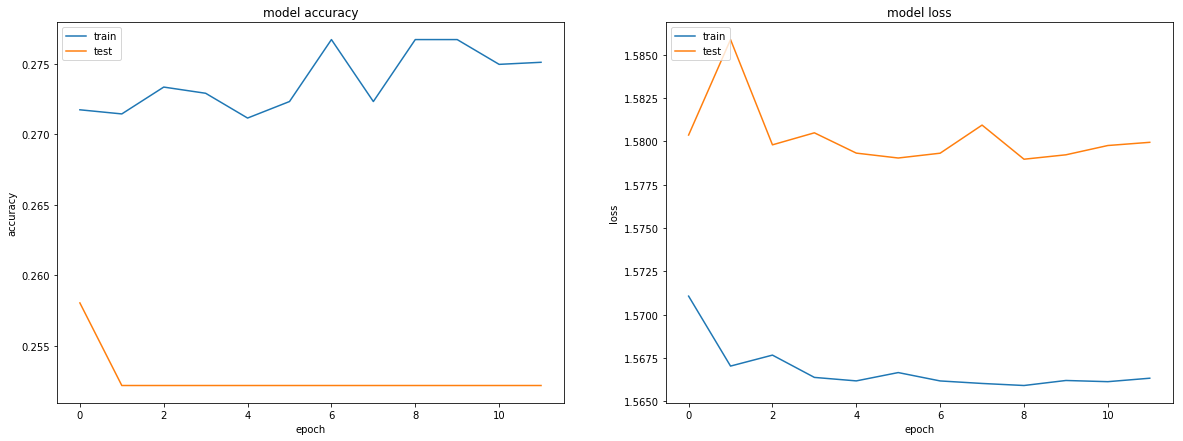

In [46]:
# 8 - Open question: find a model that is better on your dev set
#     (e.g: use a 1D ConvNet, use a better classifier, pretrain your lookup tables ..)
#     you will get point if the results on the test set are better: be careful of not overfitting your dev set too much..
#     Attach the output file "XXX_XXX_y_test_sst.txt" to your deliverable.

from keras.layers import CuDNNLSTM, Conv1D, Dropout, MaxPooling1D

w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=200000)

t = keras.preprocessing.text.Tokenizer()
words = " ".join(X_train + X_dev + X_test).split(" ")
t.fit_on_texts(words)
vocab_size = len(t.word_index) + 1
encoded_docs = t.texts_to_sequences([s.split(" ") for s in X_train])
padded_docs = keras.preprocessing.sequence.pad_sequences(encoded_docs, maxlen=max_len, padding='post')

embedding_matrix = np.zeros((vocab_size, 300))
for word, i in t.word_index.items():
    embedding_vector = w2v.word2vec.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

model = Sequential()
model.add(Embedding(vocab_size, 300, weights=[embedding_matrix], trainable=True))
model.add(CuDNNLSTM(50))
model.add(Dense(n_classes, activation='softmax'))

print(model.summary())

model.compile(loss=loss_classif,
              optimizer=keras.optimizers.Adam(lr=0.001),
              metrics=metrics_classif)
history = model.fit(padded_docs, np.vstack(Y_train), batch_size=32, epochs=12, validation_split=0.2, verbose=1)
plot_history(history)

encoded_docs = t.texts_to_sequences([s.split(" ") for s in X_test])
padded_docs = keras.preprocessing.sequence.pad_sequences(encoded_docs, maxlen=max_len, padding='post')

predictions = model.predict(padded_docs)

file = open("pretrained_lstm_y_test_sst.txt", "w")
for p in predictions:
    file.write(str(np.argmax(p)+1) + "\n")
file.close()